In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Metadata

In [2]:
game_data_src = '../data/games.csv'
summary_data_src = '../data/results.csv'

graph_folder = '../graphs'

In [3]:
teams = list(range(1, 9))

days_config = [50, 100, 500, 1000, 2000]
spawn_rates_config = [1, 2, 5, 10, 20]
games_config = [ (d, s) for d in days_config for s in spawn_rates_config ]

In [4]:
def config2colname(days, spawn_days):
	return f'{days}, {spawn_days} - Total Score'

In [5]:
colnames = [config2colname(d, s) for d, s in games_config]
gcolnames = ['Total Day', 'Spawn Rate', 'Player 1', 'Player 2', 'Player 3', 'Player 4', 'Player 1 Final Score', 'Player 2 Final Score', 'Player 3 Final Score', 'Player 4 Final Score']

In [6]:
legend = [f'Team {i}' for i in range(1, 9)]

legend_g3p123 = legend.copy()
legend_g3p123[2] = 'Team 3 (p123)'

# Helper Functions for plotting graphs

In [7]:
def annotate(plot, x, y):
	for p in plot.patches:
		plot.annotate(f'{p.get_height()}', (p.get_x() + x, p.get_height() + y))

In [8]:
def save_fig(df_plot, path):
	df_plot.get_figure().savefig(path, bbox_inches='tight')

In [9]:
es_gds = list(range(10, 60, 10))
es_sds = list(range(1, 6))

def space_out_game_days_evenly(row):
	mapping = {
		50: 10,
		100: 20,
		500: 30,
		1000: 40,
		2000: 50
	}

	return mapping[row['Game Days']]

def space_out_spawn_days_evenly(row):
	mapping = {
		1: 1,
		2: 2,
		5: 3,
		10: 4,
		20: 5
	}

	return mapping[row['Spawn Days']]

# Analysis

In [10]:
LINE, BAR, SCATTER = 0, 1, 2

### Loading Data into Dataframes

In [11]:
summary_df = pd.read_csv(summary_data_src)
game_data_df = pd.read_csv(game_data_src).filter(gcolnames)

#### Aggregate Results Data

Transform @summary_data_src into a tale with columns: Game Days, Spawn Days, Teams, Score, Games

In [12]:
total_scores_df = summary_df.filter(['Team'] + colnames).astype({k: 'int32' for k in colnames})
teams = total_scores_df['Team']

scores_df = pd.DataFrame(pd.concat([total_scores_df[cn].set_axis(teams) for cn in colnames], keys=games_config, names=['Game Days', 'Spawn Days']), columns=['Score'])
scores_df = scores_df.assign(Games=lambda _: 5)

scores_df = scores_df.reset_index()

In [13]:
scores_df.head(8)

,Game Days,Spawn Days,Team,Score,Games
0,50,1,1,635943,5
1,50,1,2,638890,5
2,50,1,3,626666,5
3,50,1,4,621265,5
4,50,1,5,615190,5
5,50,1,6,617428,5
6,50,1,7,635534,5
7,50,1,8,601658,5


#### Raw Game Runs Data

Split raw game data into two portions:

1. games where we (group 3) are not player 4
2. rest

In [14]:
game_data_df1 = game_data_df[game_data_df['Player 4'] != 3]
game_data_df2 = game_data_df[game_data_df['Player 4'] == 3]

In [15]:
# 1. filter out rows where Player 4 == 3
# 2. turn df into a table with columns: Total Day, Spawn Rate, Team, Score
# 3. computate average score

def player2team(row):
	for i in range(1,5):
		if str(i) in row['variable']:
			return row[f'Player {i}']
	
	return -1

def player2postion(row):
	for i in range(1,5):
		if str(i) in row['variable']:
			return i
	
	return -1

def format_game_data(game_data_df):
	_df = game_data_df.melt(
		id_vars=['Player 1', 'Player 2', 'Player 3', 'Player 4'],
		value_vars=['Player 1 Final Score', 'Player 2 Final Score', 'Player 3 Final Score', 'Player 4 Final Score'])
	_df['Team'] = _df.apply(player2team, axis=1)
	_df['Position'] = _df.apply(player2postion, axis=1)
	_df = _df.assign(Games=lambda _: 1)

	formatted_game_data_df = pd.concat([game_data_df.filter(gcolnames[:2])] * 4)
	formatted_game_data_df.reset_index(drop=True, inplace=True)
	formatted_game_data_df['Team'] = _df['Team']
	formatted_game_data_df['Position'] = _df['Position']
	formatted_game_data_df['Score'] = _df['value']
	formatted_game_data_df['Games'] = _df['Games']
	formatted_game_data_df = formatted_game_data_df.rename(columns={'Total Day': 'Game Days', 'Spawn Rate': 'Spawn Days'})

	return formatted_game_data_df

In [16]:
_gdf = format_game_data(game_data_df)
_gdf1 = format_game_data(game_data_df1)
_gdf2 = format_game_data(game_data_df2)

gdf1 = _gdf1.groupby(by=['Game Days', 'Spawn Days', 'Team']).sum()
gdf2 = _gdf2.groupby(by=['Game Days', 'Spawn Days', 'Team']).sum()

gdf1.head()

Position   Score  Games
Game Days Spawn Days Team                         
50        1          1           11  635943      5
                     2           13  638890      5
                     3           12  626666      5
                     4           12  621265      5
                     5           14  615190      5

## Group 3 Score: as player 4 vs as player 123

In [17]:
NOT_P4, P4 = 'not player 4', 'player 4'

df = _gdf[_gdf['Team'] == 3]
df['Position'] = df.apply(lambda row: P4 if row['Position'] == 4 else NOT_P4, axis=1)

df

/var/folders/k4/q78l8_8s7r518wk2vb68zt8r0000gn/T/ipykernel_28582/2170650415.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Position'] = df.apply(lambda row: P4 if row['Position'] == 4 else NOT_P4, axis=1)


,Game Days,Spawn Days,Team,Position,Score,Games
7,50,1,3,not player 4,127767,1
23,50,5,3,not player 4,123676,1
33,50,10,3,not player 4,125239,1
39,50,10,3,not player 4,124247,1
70,100,5,3,not player 4,257093,1
...,...,...,...,...,...,...
921,1000,5,3,player 4,1535641,1
931,1000,10,3,player 4,4216711,1
945,1000,20,3,player 4,1638867,1
961,2000,2,3,player 4,325416,1


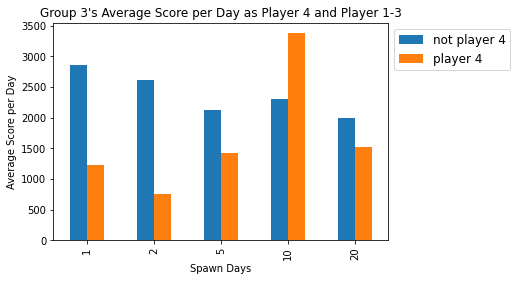

In [18]:
# Here, we want to group by Position
df1 = df.filter(['Position', 'Spawn Days', 'Score', 'Game Days']).groupby(by=['Position', 'Spawn Days']).sum() 

df1['Score'] = df1['Score'] / df1['Game Days']

df1_ax = df1.reset_index().pivot(index='Spawn Days', columns='Position', values='Score').plot.bar(
	title="Group 3's Average Score per Day as Player 4 and Player 1-3",
	ylabel='Average Score per Day'
)

df1_ax.legend(loc='best', fontsize=12, bbox_to_anchor=(1,1))
save_fig(df1_ax, '../graphs/g3_p4_vs_p123')

## Timeouts

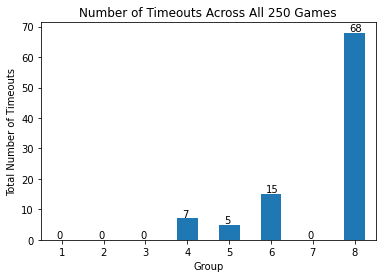

In [19]:
timeouts_plot = summary_df.plot.bar(
	x='Team', xlabel='Group',
	y='Overall Timeouts', ylabel='Total Number of Timeouts',
	legend=False, title='Number of Timeouts Across All 250 Games'
)
timeouts_plot.set_xticklabels(summary_df['Team'], rotation=0)
annotate(timeouts_plot, 0.12, 0.5)
save_fig(timeouts_plot, '../graphs/timeouts')

## Ranks

In [20]:
summary_df['50, 1 - Total Score'].rank(method='min', ascending=False)

0    2.0
1    1.0
2    4.0
3    5.0
4    7.0
5    6.0
6    3.0
7    8.0
Name: 50, 1 - Total Score, dtype: float64

## Aggregate Performance

In [21]:
# x-axis: spawn days, y-axis: average score per day
def plot_avg_score_for_spawn_days(scores_df, legend=legend):
	_scores_df = scores_df.assign(Total=scores_df['Game Days'] * scores_df['Games'])
	_scores_df['Spawn Days'] = _scores_df.apply(space_out_spawn_days_evenly, axis=1)

	_scores_df = _scores_df.groupby(by=['Spawn Days', 'Team']).sum()
	_scores_df['Score'] = _scores_df['Score'] / _scores_df['Total']

	_scores_df = _scores_df.filter(['Score']).reset_index().pivot(index='Spawn Days', columns='Team', values='Score')
	_scores_ax = _scores_df.plot.line(ylabel='Average Score per Day', title='Average Score per Day for Different Spawn Days', marker='d', linestyle='-.', figsize=(10, 8))

	_scores_ax.set_xticks(es_sds, spawn_rates_config)
	_scores_ax.legend(legend, loc='best', fontsize=12, bbox_to_anchor=(1,1))

	return _scores_ax

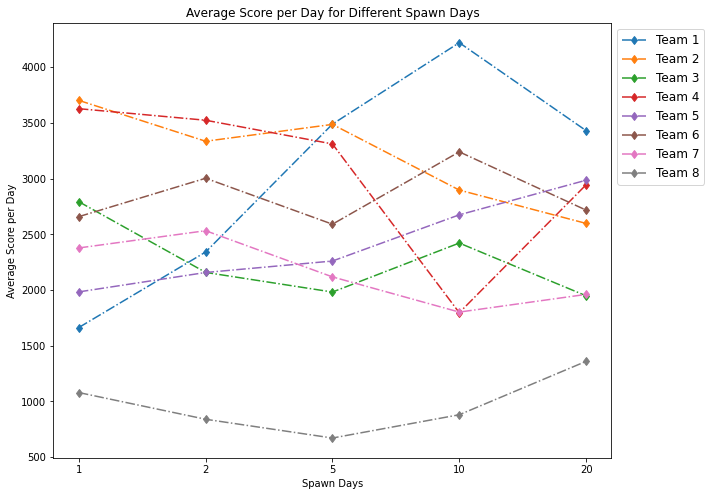

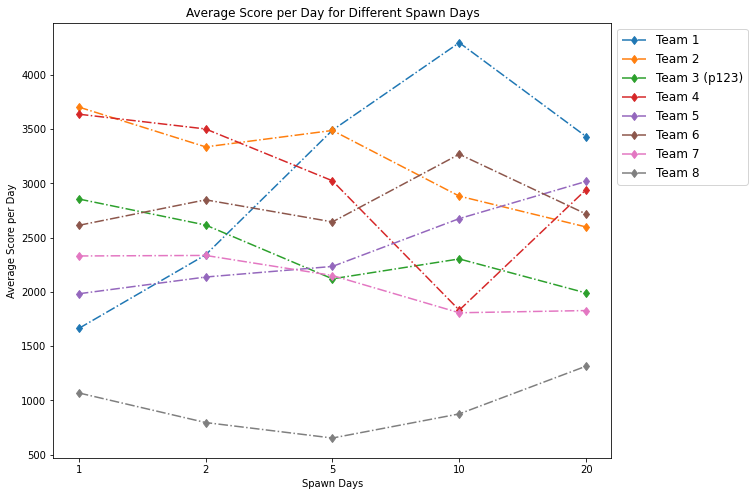

In [22]:
_scores_ax = plot_avg_score_for_spawn_days(scores_df)
save_fig(_scores_ax, f'../graphs/avg_score_per_day_by_spawn_rate')

_scores_ax = plot_avg_score_for_spawn_days(gdf1.reset_index(), legend=legend_g3p123)
save_fig(_scores_ax, f'../graphs/avg_score_per_day_by_spawn_rate_p123')

### Effect of Spawn Days on Score

In [23]:
def plot_effect_of_spawn_days(game_days, graph_type=LINE, marker='o', linestyle='--', xticks=None, figsize=(10, 10), legend_font_size=12, legend=legend):
	score_df = scores_df[scores_df['Game Days'] == game_days]
	score_df['Spawn Days'] = scores_df.apply(space_out_spawn_days_evenly, axis=1)

	score_df = score_df.pivot(index='Spawn Days', columns='Team', values='Score')
	title = f'Effect of Spawn Days on Score, {game_days} Game Days'

	if graph_type == LINE:
		score_ax = score_df.plot.line(ylabel='Total Score', title=title, marker=marker, linestyle=linestyle, figsize=figsize)
	elif graph_type == BAR:
		score_ax = score_df.plot.bar(ylabel='Total Score', title=title, figsize=figsize)
	else:
		print('unrecognized graph type: {graph_type}')
		return

	if xticks is not None:
		score_ax.set_xticks(es_sds, xticks)

	score_ax.legend(legend, loc='best', fontsize=legend_font_size, bbox_to_anchor=(1,1))
	save_fig(score_ax, f'../graphs/effect_spawn_days_{game_days}')

In [24]:
def plot_effect_of_spawn_days_all(scores_df, graph_type=LINE, marker='o', linestyle='--', xticks=None, figsize=(45, 24), legend_font_size=12, legend=legend):
	def _plot(game_days, graph_type=LINE, marker='o', linestyle='--', xticks=None, figsize=(10, 10), legend_font_size=12, ax=None):
		score_df = scores_df[scores_df['Game Days'] == game_days]
		score_df['Spawn Days'] = scores_df.apply(space_out_spawn_days_evenly, axis=1)

		score_df = score_df.pivot(index='Spawn Days', columns='Team', values='Score')
		title = f'Effect of Spawn Days on Score, {game_days} Game Days'

		if graph_type == LINE:
			score_ax = score_df.plot.line(ylabel='Total Score', title=title, marker=marker, linestyle=linestyle, ax=ax, figsize=figsize)
		elif graph_type == BAR:
			score_ax = score_df.plot.bar(ylabel='Total Score', title=title, ax=ax, figsize=figsize)
		else:
			print('unrecognized graph type: {graph_type}')
			return

		if xticks is not None:
			score_ax.set_xticks(es_sds, xticks)

		score_ax.legend(legend, loc='best', fontsize=legend_font_size, bbox_to_anchor=(1,1))

	count = 0
	nrow, ncol = 3, 2
	map_fig, map_axes = plt.subplots(nrow, ncol, figsize=figsize, constrained_layout=True)
	map_fig.delaxes(map_axes[2, 1])


	subfigsize = (figsize[0] // ncol, figsize[1] // ncol)
	for game_day in days_config:
		_plot(game_day, marker=marker, linestyle=linestyle, xticks=xticks, ax=map_axes[count // ncol, count % ncol], figsize=subfigsize, legend_font_size=legend_font_size)
		count += 1

	return map_fig


/var/folders/k4/q78l8_8s7r518wk2vb68zt8r0000gn/T/ipykernel_28582/1967506290.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score_df['Spawn Days'] = scores_df.apply(space_out_spawn_days_evenly, axis=1)
/var/folders/k4/q78l8_8s7r518wk2vb68zt8r0000gn/T/ipykernel_28582/1967506290.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score_df['Spawn Days'] = scores_df.apply(space_out_spawn_days_evenly, axis=1)
/var/folders/k4/q78l8_8s7r518wk2vb68zt8r0000gn/T/ipykernel_28582/1967506290.py:3: SettingWithCopyWar

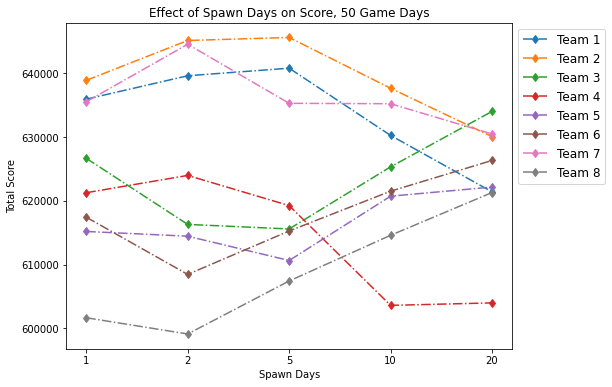

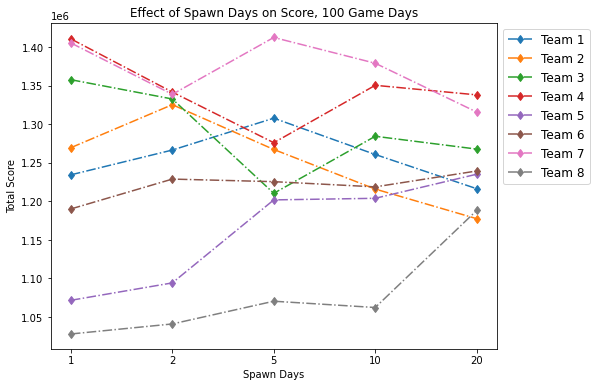

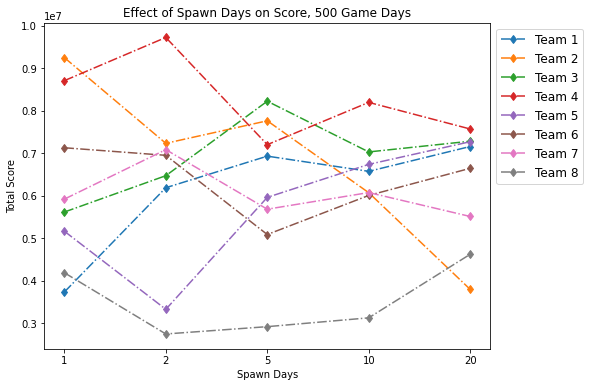

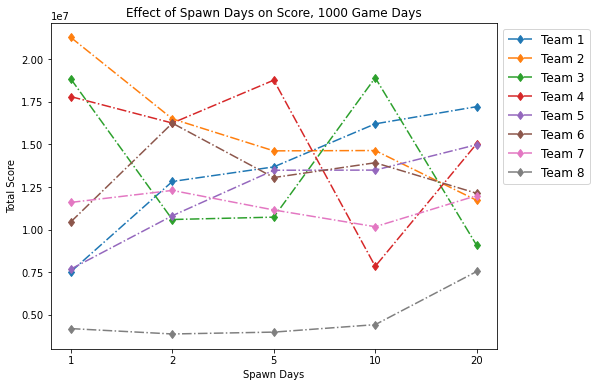

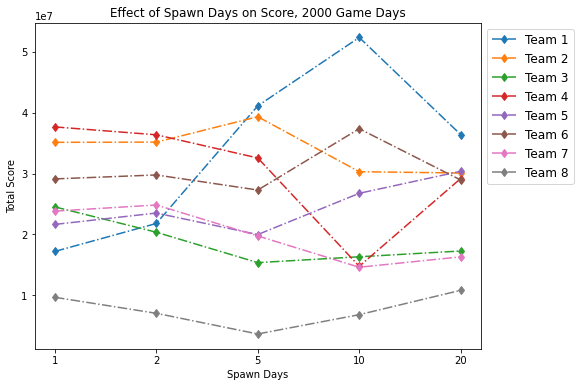

In [25]:
for game_day in days_config:
	plot_effect_of_spawn_days(game_day, marker='d', linestyle='-.', xticks=spawn_rates_config, figsize=(8, 6))

/var/folders/k4/q78l8_8s7r518wk2vb68zt8r0000gn/T/ipykernel_28582/3448104928.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score_df['Spawn Days'] = scores_df.apply(space_out_spawn_days_evenly, axis=1)
/var/folders/k4/q78l8_8s7r518wk2vb68zt8r0000gn/T/ipykernel_28582/3448104928.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score_df['Spawn Days'] = scores_df.apply(space_out_spawn_days_evenly, axis=1)
/var/folders/k4/q78l8_8s7r518wk2vb68zt8r0000gn/T/ipykernel_28582/3448104928.py:4: SettingWithCopyWar

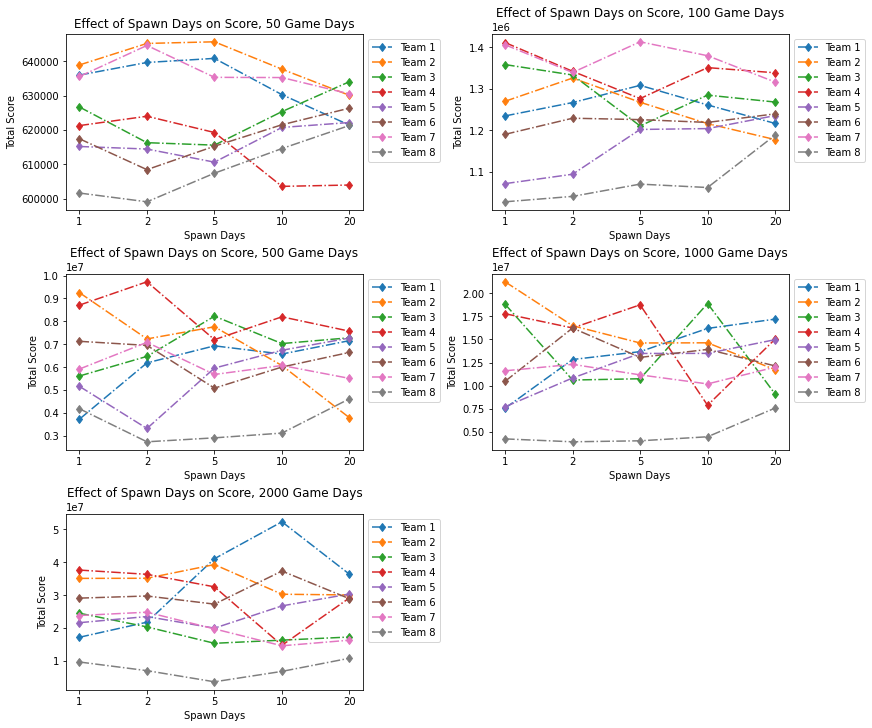

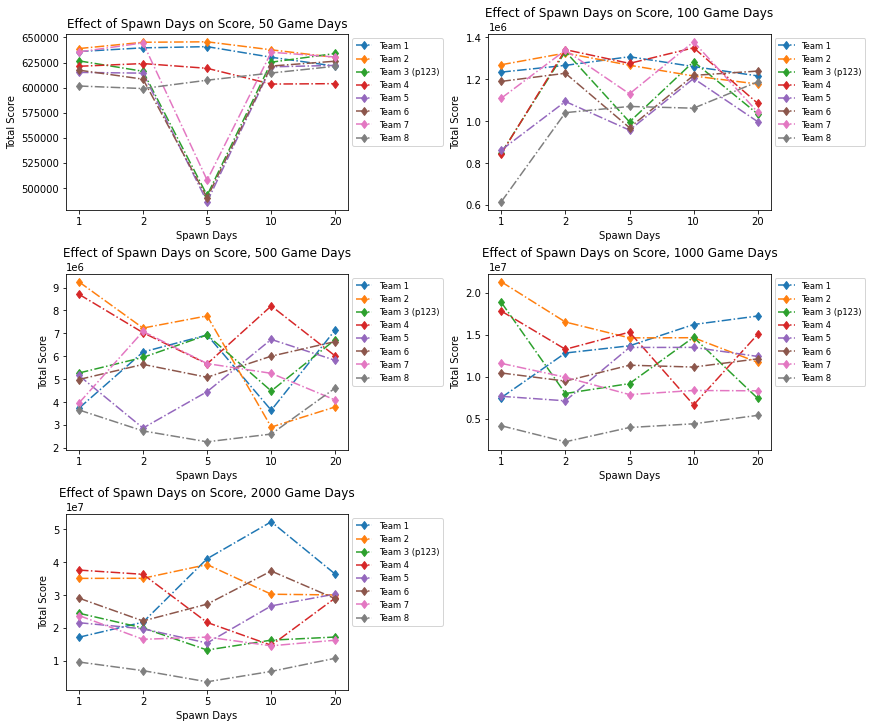

In [26]:
map_fig = plot_effect_of_spawn_days_all(scores_df, marker='d', linestyle='-.', xticks=spawn_rates_config, legend_font_size=10, figsize=(25, 20))
map_fig.savefig('../graphs/effect_spawn_days_all', bbox_inches='tight')


map_fig = plot_effect_of_spawn_days_all(gdf1.reset_index(), marker='d', linestyle='-.', xticks=spawn_rates_config, legend=legend_g3p123, legend_font_size='small', figsize=(25, 20))
map_fig.savefig('../graphs/effect_spawn_days_all_p123', bbox_inches='tight')

### Effect of Days on Score

In [27]:
def plot_effect_of_game_days(spawn_days, graph_type=LINE, marker='o', linestyle='--', xticks=None, legend_font_size=12, figsize=(5, 5), ax=None, legend=legend):
	normalized_scores_df = scores_df[scores_df['Spawn Days'] == spawn_days].assign(Total=scores_df['Game Days'] * scores_df['Games'])
	normalized_scores_df['Game Days'] = normalized_scores_df.apply(space_out_game_days_evenly, axis=1)
	normalized_scores_df['Score'] = normalized_scores_df['Score'] / normalized_scores_df['Total']

	score_df = normalized_scores_df.pivot(index='Game Days', columns='Team', values='Score')
	title = f'Effect of Game Days on Score, {spawn_days} Spawn Days'

	if graph_type == LINE:
		score_ax = score_df.plot.line(ylabel='Average Score per Day', title=title, marker=marker, linestyle=linestyle, figsize=figsize, ax=ax)
	elif graph_type == BAR:
		score_ax = score_df.plot.bar(ylabel='Average Score per Day', title=title, figsize=figsize, ax=ax)
	elif graph_type == SCATTER:
		score_ax = score_df.plot.line(ylabel='Average Score per Day', title=title, marker=marker, linestyle='None', figsize=figsize, ax=ax)
	else:
		print('unrecognized graph type: {graph_type}')
		return

	if xticks is not None:
		score_ax.set_xticks(es_gds, xticks)

	score_ax.legend(legend, loc='best', fontsize=legend_font_size, bbox_to_anchor=(1,1))
	save_fig(score_ax, f'../graphs/effect_game_days_{spawn_days}')

In [28]:
def plot_effect_of_game_days_all(scores_df, graph_type=LINE, marker='o', linestyle='--', xticks=None, legend_font_size=12, figsize=(24, 30), ax=None, legend=legend):
	def _plot(spawn_days, graph_type=LINE, marker='o', linestyle='--', xticks=None, legend_font_size=12, figsize=(5, 5), ax=None):

		normalized_scores_df = scores_df[scores_df['Spawn Days'] == spawn_days].assign(Total=scores_df['Game Days'] * scores_df['Games'])
		normalized_scores_df['Game Days'] = normalized_scores_df.apply(space_out_game_days_evenly, axis=1)
		normalized_scores_df['Score'] = normalized_scores_df['Score'] / normalized_scores_df['Total']

		score_df = normalized_scores_df.pivot(index='Game Days', columns='Team', values='Score')
		title = f'Effect of Game Days on Score, {spawn_days} Spawn Days'

		if graph_type == LINE:
			score_ax = score_df.plot.line(ylabel='Average Score per Day', title=title, marker=marker, linestyle=linestyle, figsize=figsize, ax=ax)
		elif graph_type == BAR:
			score_ax = score_df.plot.bar(ylabel='Average Score per Day', title=title, figsize=figsize, ax=ax)
		elif graph_type == SCATTER:
			score_ax = score_df.plot.line(ylabel='Average Score per Day', title=title, marker=marker, linestyle='None', figsize=figsize, ax=ax)
		else:
			print('unrecognized graph type: {graph_type}')
			return

		if xticks is not None:
			score_ax.set_xticks(es_gds, xticks)

		score_ax.legend(legend, loc='best', fontsize=legend_font_size, bbox_to_anchor=(1,1))

	count = 0
	nrow, ncol = 3, 2
	map_fig, map_axes = plt.subplots(nrow, ncol, figsize=figsize, constrained_layout=True)
	map_fig.delaxes(map_axes[2, 1])

	subfigsize = (figsize[0] // ncol, figsize[1] // ncol)
	for spawn_day in spawn_rates_config:
		_plot(spawn_day, graph_type=graph_type, marker=marker, linestyle=linestyle, xticks=xticks, ax=map_axes[count // ncol, count % ncol], legend_font_size='small', figsize=subfigsize)
		count += 1

	return map_fig

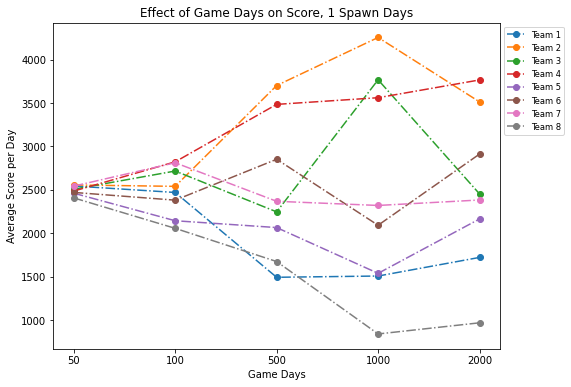

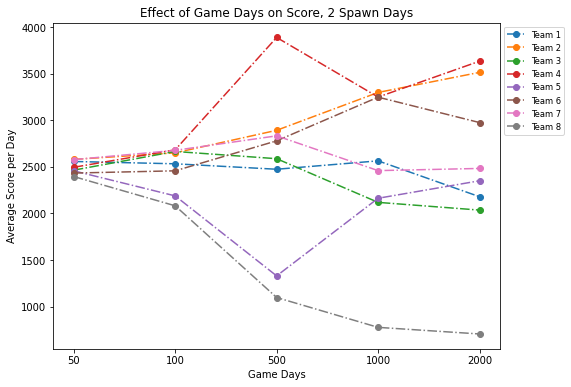

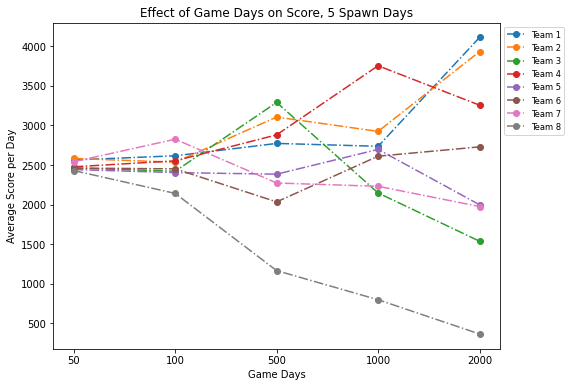

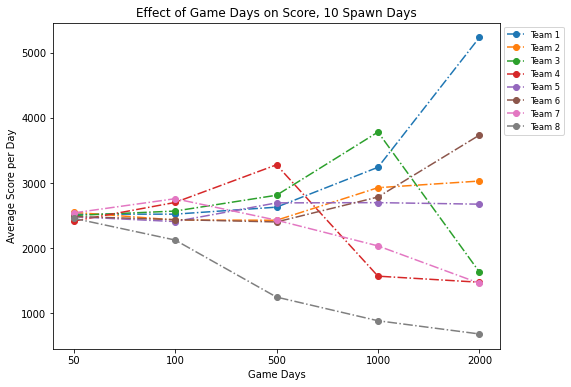

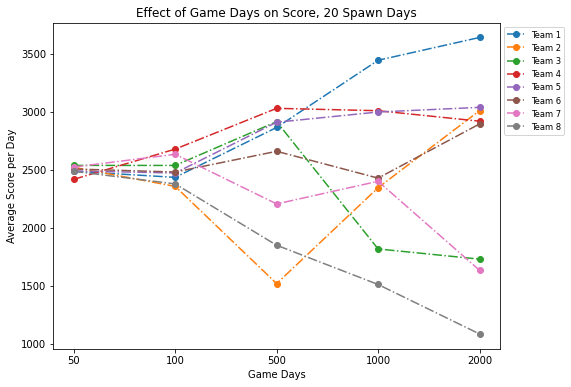

In [29]:

for spawn_day in spawn_rates_config:
	plot_effect_of_game_days(spawn_day, graph_type=LINE, marker='o', linestyle='-.', xticks=days_config, figsize=(8, 6), legend_font_size='small')

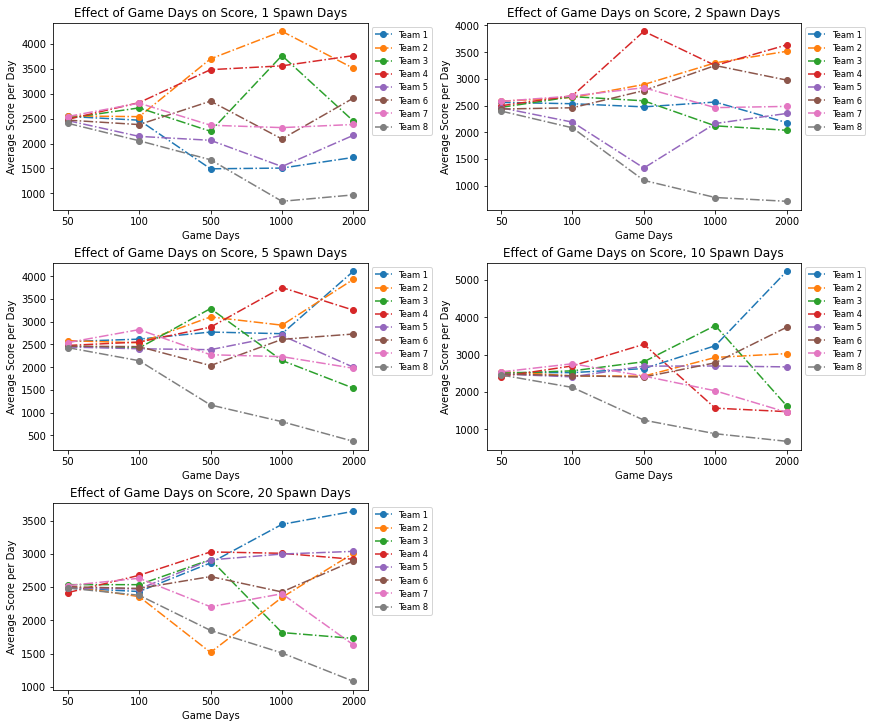

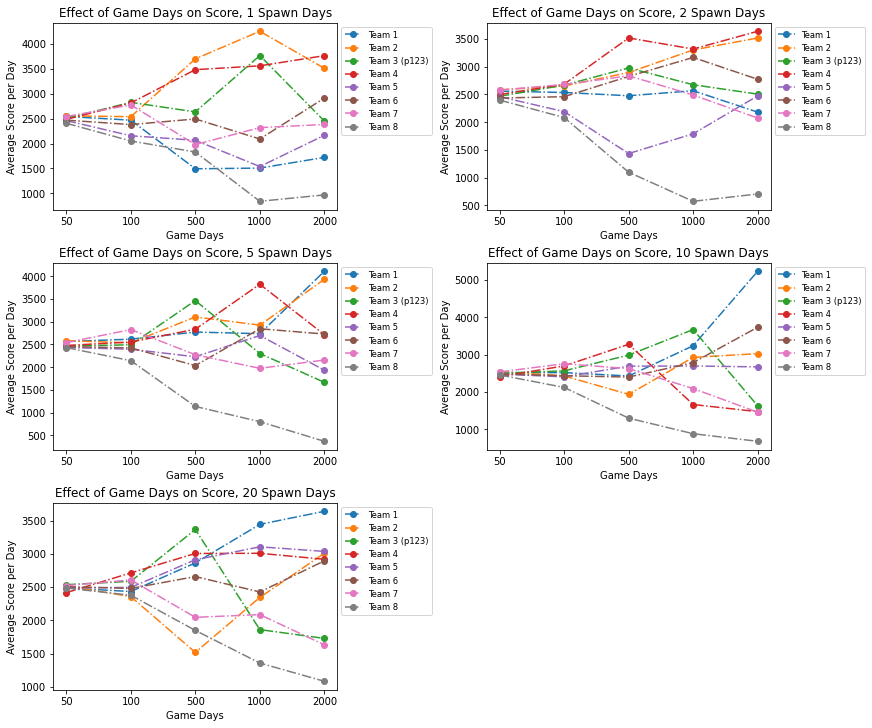

In [30]:
map_fig = plot_effect_of_game_days_all(scores_df, marker='o', linestyle='-.', xticks=days_config, figsize=(25, 20))
save_fig(map_fig, '../graphs/effect_game_days_all')

map_fig = plot_effect_of_game_days_all(gdf1.reset_index(), marker='o', linestyle='-.', xticks=days_config, figsize=(25, 20), legend=legend_g3p123)
save_fig(map_fig, '../graphs/effect_game_days_all_p123')